In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

Загрузка библиотеки с FCA

In [2]:
import os
import sys
BASE_PATH = os.path.realpath('..')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

from lib import fca_interp as fcai

# Load Data

In [3]:
from sklearn.datasets import load_boston

boston_data = load_boston()
boston_ds = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names'])
boston_ds['target'] = boston_data['target']
print(boston_ds.shape)
boston_ds.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
train_feats = list(boston_ds.drop('target',1).columns)
y_feat = 'target'

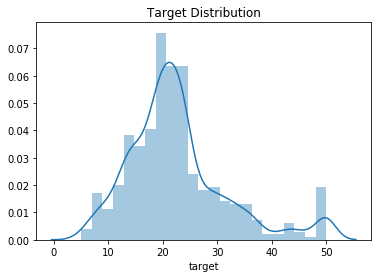

In [5]:
sns.distplot(boston_ds[y_feat])
plt.title('Target Distribution')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,  y_test = train_test_split(boston_ds[train_feats], boston_ds[y_feat], test_size=0.1)
[x.shape for x in [X_train, X_test, y_train,  y_test]]

[(455, 13), (51, 13), (455,), (51,)]

# Check competitors qualities

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [8]:
def calc_metrics(model_name, y_train, y_test, preds_train, preds_test, ds_full=None):
    q_dict = {}
    for metric in [mean_absolute_error, mean_squared_error, r2_score]:
        q_dict[(metric.__name__,"train")] = metric(y_train, preds_train)
        q_dict[(metric.__name__,"test")] = metric(y_test, preds_test)
    q_dict_ = {model_name:q_dict}
    q_dict = q_dict_
    del q_dict_
    q_dict = pd.DataFrame(q_dict).reset_index().rename(columns={'level_0':'metric','level_1':'ds'})
    
    if ds_full is not None:
        if model_name in ds_full.columns:
            ds_full = ds_full.drop(model_name, 1)
        ds_full = ds_full.merge(q_dict, on=['metric','ds'])
    else:
        ds_full = q_dict
    return ds_full

In [9]:
def plot_metrics(ds, figsize=(15,5)):
    plt.figure(figsize=figsize)
    for m_idx, metric in enumerate(ds['metric'].unique()):
        cds = ds[ds['metric']==metric]

        plt.subplot(1,3,m_idx+1)
        for ds_idx, ds_type in enumerate(['train','test']):
            vals = cds[cds['ds']==ds_type].drop(['metric','ds'],1).values[0]
            plt.barh(np.arange(len(vals))+0.3*ds_idx, vals, height=0.3, label=ds_type)
            for v_idx, v in enumerate(vals):
                plt.text(v, v_idx-0.05+0.3*ds_idx, f"{v:.2f}")
        plt.legend(loc='lower left')
        plt.yticks(np.arange(cds.shape[1]-2), cds.drop(['metric','ds'],1).columns, rotation=0)
        plt.title(metric)
    plt.tight_layout()
    plt.show()    

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool


models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(),
          XGBRegressor(), CatBoostRegressor()]
comp_qualities = None
for m in tqdm(models):
    if type(m)==CatBoostRegressor:
        p_train, p_test = Pool(X_train, y_train), Pool(X_test, y_test)
        m.fit(p_train, verbose=False)
        preds_train, preds_test = [m.predict(p) for p in [p_train, p_test]]
    else:
        m.fit(X_train, y_train)
        preds_train, preds_test = [m.predict(p) for p in [X_train, X_test]]
    
    comp_qualities = calc_metrics(m.__class__.__name__, y_train, y_test, preds_train, preds_test, comp_qualities)

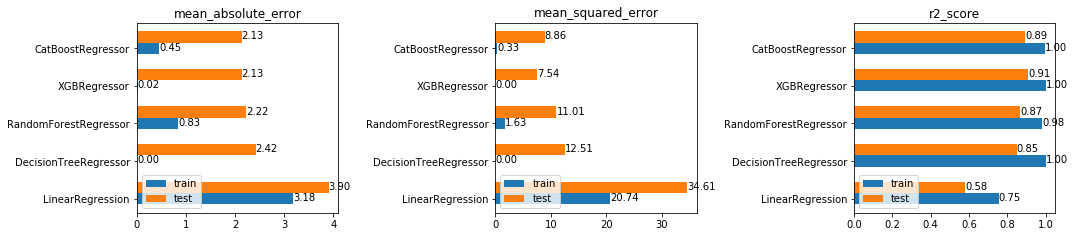

In [11]:
plot_metrics(comp_qualities, figsize=(15,3.4))

# Multi-valued contexts

Работа с узорными структурами.


Сейчас реализованы только:
* интервальная узорная структура ($g^{'} = [a_{min}, a_{max}], \quad g_1^{'}\sqcap g_2^{'} = [min(a_{1_{min}}, a_{2_{min}}), max(a_{1_{max}}, a_{2_{max}}  )],\quad$ где $g$ - объект, $a_{min}, a_{max} \in \mathbb{R}$)
* узорная структура на множествах ($g^{'} = A, \quad g_1^{'}\sqcap g_2^{'} = A_1 \cap A_2,\quad$ где $g$ - объект, $A \subseteq W$,$W$ - множество каких-то значений)

## Lattice construction on big data for supervised learning

На больших контекстах нет смысла рассчитывать все понятия. Будем аппроксимировать решётку через объединение нескольких деревьев решений (про это будет моя магистерская). Возможно такую решётку нельзя будет рассматривать, как средство для KDD (тут лучше пользоваться алгоритмом sofia, который у меня пока не имплементирова), зато её можно использовать для классификации объектов.

### Конструирование аппроксимированной решётки

Делим контекст на обучающую и тестовую выборки.

In [12]:
fcai = reload(fcai)

In [13]:
np.random.seed(42)

mvcntx_train = fcai.MultiValuedContext(X_train, y_true=y_train, cat_attrs=[])
mvcntx_test = fcai.MultiValuedContext(X_test, y_true=y_test, cat_attrs=[])
fm_mv = fcai.FormalManager(mvcntx_train, task_type='Regression')

Строим понятия на обучающей выборке

In [14]:
%%time
fm_mv.construct_concepts(
    use_tqdm=True, algo='RandomForest',
    rf_params={})
print(len(fm_mv.get_concepts()))


29623
CPU times: user 19.5 s, sys: 265 ms, total: 19.7 s
Wall time: 19.6 s


Небольшой костыль - добавляем в решётку самое меньшее понятие, которое ничего не описывает. Это нужно только для красивой визуализации и корректного расчёта индексов стабильности.

In [15]:
fm_mv._concepts.add(
    fcai.PatternStructure(
        extent=[], intent=None, cat_feats=[],
        idx=len(fm_mv.get_concepts()), metrics={'mean_y_true':0} ) )

Строим остовное дерево на понятиях. Для классификации объектов не обязательно рассчитывать всю решётку, все связи между понятиями.

In [16]:
%%time
fm_mv.construct_lattice(use_tqdm=True, only_spanning_tree=True)


CPU times: user 7.46 s, sys: 83.9 ms, total: 7.55 s
Wall time: 7.49 s


Небольшой костыль, чтобы можно было визуализировать получившееся остовное дерево. При расчёте решётки понятий этот код происходит автоматически.

In [17]:
for c in tqdm(fm_mv.get_concepts()):
    c._up_neighbs = {c._up_neighb_st} \
        if c._up_neighb_st is not None else None
    c._low_neighbs = c._low_neighbs_st

fm_mv._calc_concept_levels() # расчёт горизонтальной координаты при отображении понятия

Рассчёт дополнительных метрик для регрессии

Визуализируем остовное дерево

### Классификация с помощью решётки

Алгоритм классификации объекта $g$:
1. Найти множество $C^g$ минимальных (по включению) понятий, которые описывают объект $g$
2. Предсказание для объекта $g$ = среднее из предсказаний каждого понятия из $C^g$

Получаем предсказания для каждого объекта из обучающего и тестового контекстов

In [18]:
%%time
metrics = ['mean_y_true']
preds_train = fm_mv.predict_context(mvcntx_train, metric=metrics)
preds_test = fm_mv.predict_context(mvcntx_test, metric=metrics)
preds_test[[0,10,20]]

CPU times: user 17.1 s, sys: 24.5 ms, total: 17.1 s
Wall time: 17.1 s


matrix([[24.40417171],
        [21.61910323],
        [21.81836699]])

Качество на обучающей и тестовой выборке

In [19]:
comp_qualities = calc_metrics('FCA basic', y_train, y_test, preds_train, preds_test, comp_qualities)

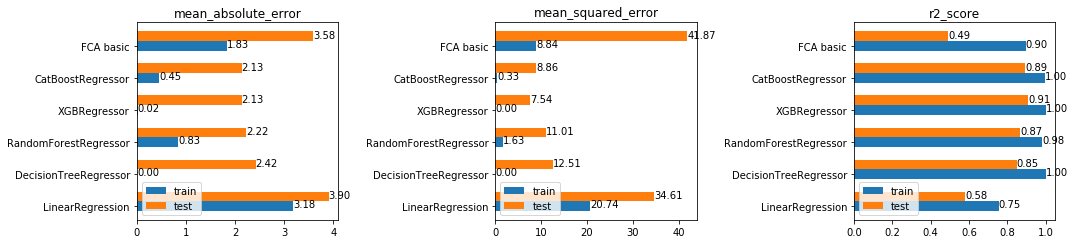

In [20]:
plot_metrics(comp_qualities, (15, 3.5))

# FCA with Linear Regression Weights

In [21]:
def predict_fca(fm, cntx, metric, W, normalized=False):
    metric = metric if type(metric) == list else [metric]
    mvals = np.array(
        [[c._metrics[m] for m in metric] for c in sorted(fm.get_concepts(), key=lambda c: c.get_id())])
    
    m_id = 0
    
    obj_preds_cncpts = fm.trace_context(cntx)[0]
    n_objs, n_cncpts = len(obj_preds_cncpts), len(fm.get_concepts())
    
    X_ = np.array([(mvals[c_id][m_id],g, c_id)
                   for g, c_ids in obj_preds_cncpts.items() for c_id in c_ids])
    X = csr_matrix((X_[:, 0], (X_[:, 1].astype(int), X_[:, 2].astype(int))),
            shape=(n_objs, n_cncpts))
    
    preds = X.dot(W)#/(X>0).dot(W) 
    if normalized:
        preds = preds/(X>0).dot(W)
    return preds, X

In [22]:
from scipy.sparse import csr_matrix

In [23]:
def train_rflr(fm, cntx_train, y_train, algo):
    n_objs, n_cncpts = len(cntx_train.get_objs()), len(fm.get_concepts())
    W0 =  np.ones(n_cncpts)/n_cncpts
    
    
    preds_train_0, X_train_0 = predict_fca(fm, cntx_train, 'mean_y_true', W0)
    
    lr = algo()
    lr.fit(X_train_0, y_train)
    W_lr = lr.coef_
    
    return W_lr

In [24]:
def balance_weights(fm, W):
    W1 = W.copy()
    for c_idx in range(len(fm.get_concepts())-1,-1,-1):
        if W1[c_idx]==0:
            c = fm.get_concept_by_id(c_idx)
            ln_weights = W1[list(c._low_neighbs)]
            W1[c_idx] = ln_weights.mean()
    return W1

In [25]:
from sklearn.linear_model import Ridge

All equal weights

In [26]:
W0 = np.ones(len(fm_mv.get_concepts()))/np.ones(len(fm_mv.get_concepts()))*10

In [27]:
preds_train = predict_fca(fm_mv, mvcntx_train, 'mean_y_true', W0, normalized=True)[0]
preds_test = predict_fca(fm_mv, mvcntx_test, 'mean_y_true', W0, normalized=True)[0]
preds_test[np.isnan(preds_test)] = y_train.mean()

comp_qualities = calc_metrics('FCA equal weights norm', y_train, y_test, preds_train, preds_test, comp_qualities)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide



Linear And Ridge Regression Weights

In [28]:
for algo_name, algo in [('LR',LinearRegression), ('Ridge', Ridge)]:
    W = train_rflr(fm_mv, mvcntx_train, y_train, algo)
    Wb = balance_weights(fm_mv, W)

    for is_bal_name, w in [('',W), (' balanced',Wb)]:
        preds_train = predict_fca(fm_mv, mvcntx_train, 'mean_y_true', w, normalized=True)[0]
        preds_test = predict_fca(fm_mv, mvcntx_test, 'mean_y_true', w, normalized=True)[0]
        preds_test[np.isnan(preds_test)] = y_train.mean()
        comp_qualities = calc_metrics(
            f'FCA {algo_name}{is_bal_name} norm',
            y_train, y_test, preds_train, preds_test, comp_qualities
        )

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

Mean of empty slice.

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

Mean of empty slice.

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide



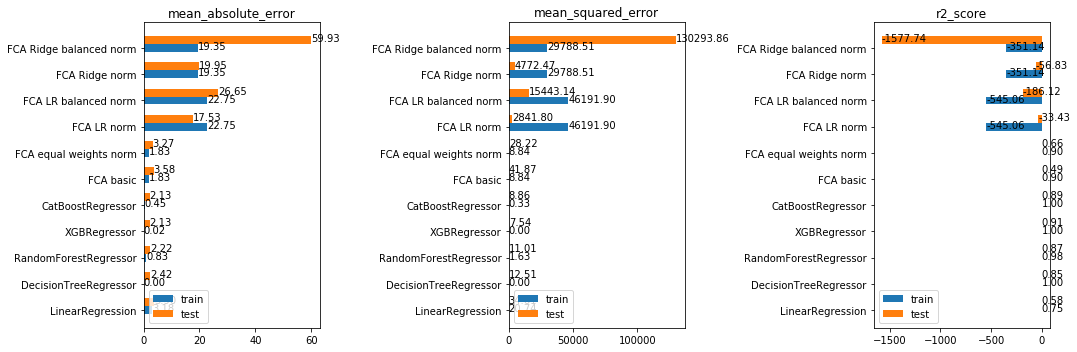

In [29]:
plot_metrics(comp_qualities)

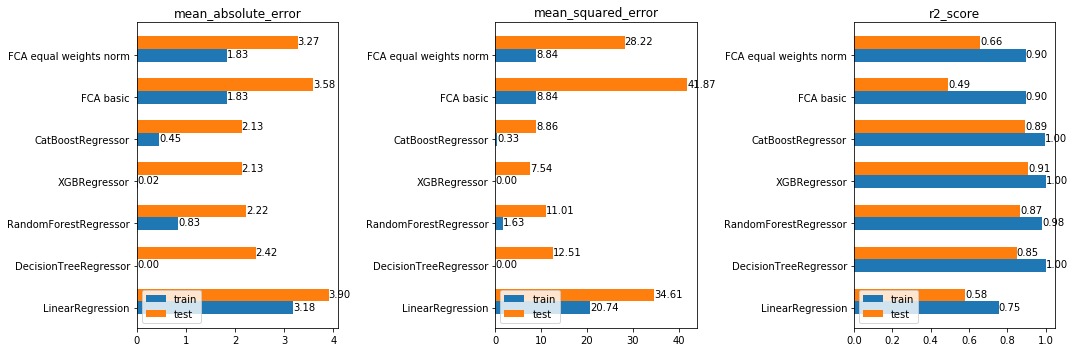

In [30]:
plot_metrics(comp_qualities.drop([f for f in comp_qualities.columns if any([f_ in f for f_ in ['LR','Ridge']])],1))

## Aggregation + Interesting Measures

In [31]:
def predict_fca_top_intermeas(fm, cntx, measure_func, n_top_cncpts, metric='mean_y_true', aggfunc='mean'):
    wvals = np.array([measure_func(c) for c in fm.sort_concepts()])
    mvals = np.array([c._metrics[metric] for c in fm.sort_concepts()])

    obj_preds_cncpts = fm.trace_context(cntx)[0]
    n_objs, n_cncpts = len(obj_preds_cncpts), len(fm.get_concepts())

    wvals_ths = {g: np.sort(np.unique(wvals[c_ids]))[-n_top_cncpts:].min() if len(c_ids)>0 else None
             for g, c_ids in obj_preds_cncpts.items()}

    if aggfunc == 'mean':
        X_ = np.array([(1,g, c_id)
                       for g, c_ids in obj_preds_cncpts.items()
                       for c_id in c_ids if wvals[c_id]>=wvals_ths[g]])
        X = csr_matrix((X_[:, 0], (X_[:, 1].astype(int), X_[:, 2].astype(int))),
                shape=(n_objs, n_cncpts))
        Xm = X.multiply(mvals)
    
        preds = np.array(Xm.sum(1)/X.sum(1))
    elif aggfunc in ['min','max']:
        dct = {g: [mvals[c_id] for c_id in c_ids if wvals[c_id]>=wvals_ths[g]]
         for g,c_ids in obj_preds_cncpts.items()}
        f_ = min if aggfunc=='min' else max
        preds = np.array([f_(dct[g]) if len(dct[g])>0 else np.nan for g in sorted(dct.keys())]).reshape(-1,1)
    else:
        raise ValueError(f'Unknown aggfunc {aggfunc}. In predict_fca_top_intermeas')
    
    return preds

In [32]:
fm_mv.construct_lattice(use_tqdm=True, only_spanning_tree=False)

KeyboardInterrupt: 

In [33]:
fm_mv.calc_stability_approx(use_tqdm=True)

In [34]:
measure_funcs = {
    'support asc': lambda c: len(c.get_extent()),
    'support desc': lambda c: -len(c.get_extent()),
    #'stability asc': lambda c: fcai.get_not_none(c._metrics['log_stab_min_bound'],0),
    #'stability desc': lambda c: -fcai.get_not_none(c._metrics['log_stab_min_bound'],1),
}

In [35]:
n_max_objects = max([len(c_ids) for g, c_ids in fm_mv.trace_context(mvcntx_train)[0].items()])

In [36]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
intermeas_qualities = None

for m_func_name, m_func in tqdm(measure_funcs.items()):
    for aggfunc in tqdm(['mean','min','max'], leave=False):
        for n_top_cncpts in tqdm(np.unique(np.linspace(1, n_max_objects, 10).astype(int)), leave=False):
            preds_train = predict_fca_top_intermeas(
                fm_mv, mvcntx_train, m_func, n_top_cncpts, aggfunc=aggfunc)
            preds_test = predict_fca_top_intermeas(
                fm_mv, mvcntx_test, m_func, n_top_cncpts, aggfunc=aggfunc)
            
            preds_test = np.nan_to_num(preds_test, nan=fm_mv._top_concept._metrics['mean_y_true'])
            
            intermeas_qualities = calc_metrics(
                f"intermeas={m_func_name}_aggfunc={aggfunc}_ncncpts={n_top_cncpts}",
                y_train, y_test, preds_train, preds_test, intermeas_qualities)

In [38]:
cdss= []
for f in intermeas_qualities.drop(['metric','ds'],1).columns:
    cds = intermeas_qualities[['metric','ds',f]].rename(columns={f:'metric_value'})
    cds['type'] = f
    cdss.append(cds)
cds = pd.concat(cdss)
del cdss

In [39]:
cds['interest_measure'] = [x.split('_')[0].split('=')[1] for x in cds['type']]
cds['aggfunc'] = [x.split('_')[1].split('=')[1] for x in cds['type']]
cds['n_top_concepts'] = [int(x.split('_')[2].split('=')[1]) for x in cds['type']]

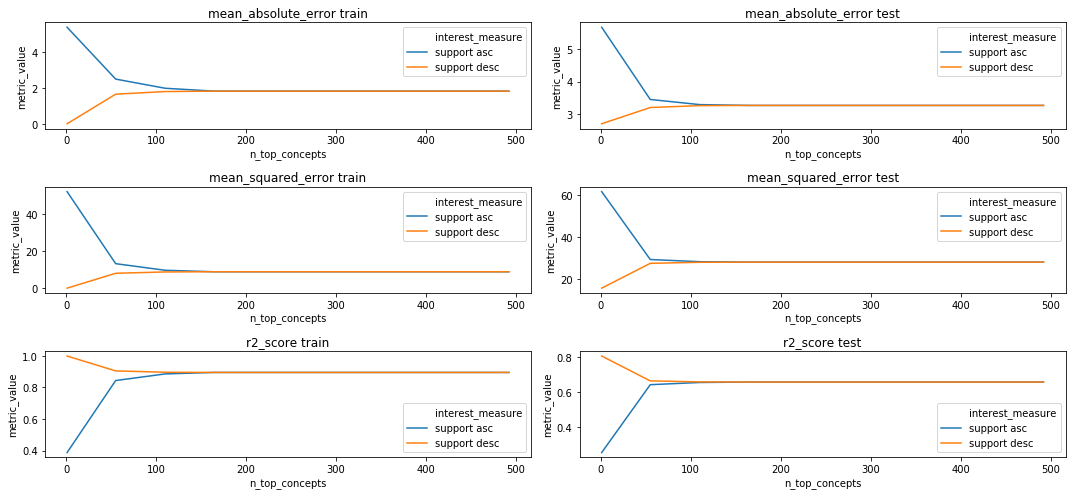

In [40]:
plt.figure(figsize=(15,7))
for m_idx, m in enumerate(cds['metric'].unique()):
    for ds_idx, ds_type in enumerate(['train','test']):
        plt.subplot(3,2,m_idx*2+ds_idx+1)
        sns.lineplot(x='n_top_concepts', y='metric_value', hue='interest_measure',
                     data=cds[(cds['aggfunc']=='mean')&(cds['metric']==m)&(cds['ds']==ds_type)]
                    )
        plt.title(f"{m} {ds_type}") 
    
plt.tight_layout()
plt.show()

In [41]:
comp_qualities[['metric','ds','LinearRegression','DecisionTreeRegressor','RandomForestRegressor','XGBRegressor','CatBoostRegressor']]

,metric,ds,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,XGBRegressor,CatBoostRegressor
0,mean_absolute_error,test,3.899960,2.415686,2.217176,2.130492,2.130702
1,mean_absolute_error,train,3.181671,0.000000,0.833662,0.018205,0.446777
2,mean_squared_error,test,34.605654,12.509804,11.010421,7.537323,8.864048
3,mean_squared_error,train,20.736632,0.000000,1.633167,0.000691,0.330176
4,r2_score,test,0.580692,0.848422,0.866589,0.908672,0.892597
5,r2_score,train,0.754862,1.000000,0.980694,0.999992,0.996097


# SAMME approach

In [42]:
fm = fm_mv
cntx = mvcntx_train

In [47]:
Wg = np.ones(len(cntx.get_objs()))/len(cntx.get_objs())
for idx in range(100):
    #W = [Wg[c.get_extent()].mean() for c in fm_mv.sort_concepts()]
    W = [np.mean(Wg[c.get_extent()]) for c in fm_mv.sort_concepts()]
    y_pred = predict_fca(fm_mv, mvcntx_train, 'mean_y_true',W, normalized=True)[0]
    
    errv = (y_pred-y_train.values)**2
    Wg = errv/errv.max()
    #err = (Wg*errv).sum()/Wg.sum()
    #alpha = np.log((1-err/errv.max())/(errv/errv.max()))+np.log(len(Wg)-1)
    #Wg = Wg*np.exp(alpha*errv/errv.max())
    #Wg = Wg/Wg.max()
    print(f"iter: {idx}, MSE: {((y_pred-y_train)**2).mean()}")

iter: 0, MSE: 8.84154725209282
iter: 1, MSE: 6.014000410166581
iter: 2, MSE: 5.755795777592318
iter: 3, MSE: 5.6175725292365755
iter: 4, MSE: 5.5816303272088525
iter: 5, MSE: 5.570467765529828
iter: 6, MSE: 5.566678682897674
iter: 7, MSE: 5.5654994106591476
iter: 8, MSE: 5.5652489598342045
iter: 9, MSE: 5.565050662040529
iter: 10, MSE: 5.565085449844614
iter: 11, MSE: 5.565030655822482
iter: 12, MSE: 5.565055813651666
iter: 13, MSE: 5.5650378635957995
iter: 14, MSE: 5.56504764557064
iter: 15, MSE: 5.565041726732482
iter: 16, MSE: 5.565045045606725
iter: 17, MSE: 5.565043139318027
iter: 18, MSE: 5.565044207560722
iter: 19, MSE: 5.565043606514877
iter: 20, MSE: 5.56504394157061
iter: 21, MSE: 5.56504375490193
iter: 22, MSE: 5.565043858472245
iter: 23, MSE: 5.565043801083449
iter: 24, MSE: 5.5650438328147
iter: 25, MSE: 5.565043815290051
iter: 26, MSE: 5.565043824956489
iter: 27, MSE: 5.565043819629069
iter: 28, MSE: 5.565043822562838
iter: 29, MSE: 5.56504382094819
iter: 30, MSE: 5.56504

In [152]:
comp_qualities

,metric,ds,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,XGBRegressor,CatBoostRegressor,FCA basic,FCA equal weights norm,FCA LR norm,FCA LR balanced norm,FCA Ridge norm,FCA Ridge balanced norm
0,mean_absolute_error,test,3.854876,3.296078,2.733706,2.279867,2.130291,4.833858,4.308368,12.107194,11.618842,6.686972,7.091015
1,mean_absolute_error,train,3.223111,0.000000,0.819057,0.016707,0.437353,2.256329,2.256329,7.807684,7.807684,10.026008,10.026008
2,mean_squared_error,test,25.133913,29.474314,17.322104,11.346674,9.593614,81.173109,45.097732,502.159069,396.999526,98.951849,107.299493
3,mean_squared_error,train,21.583287,0.000000,1.598812,0.000578,0.317192,10.306698,10.306698,389.742530,389.742530,3061.127333,3061.127333
4,r2_score,test,0.752782,0.710089,0.829619,0.888394,0.905637,0.201577,0.556416,-3.939262,-2.904908,0.026705,-0.055403
5,r2_score,train,0.738260,1.000000,0.980611,0.999993,0.996153,0.875011,0.875011,-3.726390,-3.726390,-36.122151,-36.122151
